Imports

In [160]:
import os

import matplotlib.pyplot as plt
import numpy as np
import json
from skmultilearn.model_selection import iterative_train_test_split
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix
from PIL import Image
import seaborn as sns

import torch
import torchvision.models as models
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights
from torchvision.transforms import RandomHorizontalFlip, RandomRotation


In [161]:
dataset_directory = "../Dataset Generation/dataset"

# Image and label directory arrays
images = []
labels = []

for recipe_folder in os.listdir(dataset_directory):
    recipe_path = os.path.join(dataset_directory, recipe_folder)
    allergens_file = os.path.join(recipe_path, 'allergens.json')

    if os.path.isfile(allergens_file):
        with open(allergens_file, 'r') as f:
            data = json.load(f)
            allergens = data['allergens']
            image = data['images'][0]
            images.append(os.path.join(dataset_directory, recipe_folder, image))
            labels.append(allergens)

            # for image in data['images']:
            #     images.append(os.path.join(dataset_directory, recipe_folder, image))
            #     labels.append(allergens)

In [162]:
x = np.array(images).reshape(-1,1) # iterative_train_test_split expects 2d array
y = np.array(labels)

In [163]:
label = 0 # Allergen label (0-13)

In [164]:
positives = np.where(y[:, label] == 1)[0]
negatives = np.where(y[:, label] == 0)[0]

In [165]:
print(len(positives))
print(len(negatives))

13523
22680


In [166]:
downsampled_negatives = np.random.choice(negatives, size=len(positives), replace=False) # randomly select negatives, same amount as positive

balanced_indexes = np.concatenate([positives, downsampled_negatives]) # Index for balanced positive and negative labels

x = x[balanced_indexes]
y = y[balanced_indexes, label] # only label 0

In [167]:
y = y.reshape(-1,1) # split expects 2d array
x_train, y_train, x_temp, y_temp = iterative_train_test_split(x, y, test_size=0.3)  # http://scikit.ml/stratification.html
x_test, y_test, x_val, y_val = iterative_train_test_split(x_temp, y_temp, test_size=0.5)

In [168]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Hyperparameters

In [169]:
# Parameters
learning_rate = 1e-4
batch_size = 64
epochs = 5
prediction_threshold = 0.5

Dataset Loader

In [170]:
# Dataset loader class shell: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

class FoodAllergenDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, target_transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx][0]
        image = Image.open(img_path).convert('RGB') # Convert all images to 3 channel RGB as dataset contains some 4 channel RGBA images
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [171]:
# Transform images to tensors and resize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Test more transforms later in training to improve accuracy - cropping, rotation, centering, flipping etc.

In [172]:
train_dataset = FoodAllergenDataset(x_train, y_train, transform=transform)
val_dataset = FoodAllergenDataset(x_val, y_val, transform=transform)
test_dataset = FoodAllergenDataset(x_test, y_test, transform=transform)

In [173]:
# Create Train Test Val DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Set Accelerator Device

In [174]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


CNN Model Architecture

In [175]:
# Sample CNN model from pytorch
class Net(nn.Module):
    def __init__(self, num_labels=14):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [176]:
resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
resnet.fc = nn.Linear(resnet.fc.in_features, 1)

In [177]:
model = Net().to(device)
#model = resnet.to(device)
print(model)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)


Loss Function and Optimizer

In [178]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Training Loop

In [179]:
# https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0.0

    for batch, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        prediction = model(images)
        loss = loss_fn(prediction, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # Accumulate loss for this batch
        total_loss += loss.item()

        if batch % 100 == 0:
            current = batch * len(images)
            print(f"loss: {loss.item():.7f} [{current:5d}/{size:5d}]")

    # Return average training loss for this epoch
    return total_loss / len(dataloader)

In [180]:
def validate_one_epoch(dataloader, model, loss_fn):
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            prediction = model(images)
            loss = loss_fn(prediction, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(dataloader)
    print(f"Validation loss: {avg_val_loss:.7f}")

    # Return average validation loss for this epoch
    return avg_val_loss

In [181]:
"""
https://www.geeksforgeeks.org/how-to-handle-overfitting-in-pytorch-models-using-early-stopping/

patience: Number of epochs to wait before stopping if no improvement.
delta: Minimum change in the monitored quantity to qualify as an improvement.
best_score, best_model_state: Track the best validation score and model state.
call method: Updates the early stopping logic.
"""

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

In [182]:
# https://pytorch.org/tutorials/beginner/saving_loading_models.html
def save_model_checkpoint(epoch, model, optimizer, training_losses, validation_losses):
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "training_losses": training_losses, # full loss history, so that post-checkpoint models will have correct loss graph
        "validation_losses": validation_losses
    }, "model.pt")

In [183]:
# Store losses to be graphed
training_losses = []
validation_losses = []
starting_epoch = 0

In [184]:
# # https://pytorch.org/tutorials/beginner/saving_loading_models.html
# # Only run if loading from checkpoint
# checkpoint = torch.load("model.pt")
# model.load_state_dict(checkpoint["model_state_dict"])
# optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# starting_epoch = checkpoint["epoch"]
# training_losses = checkpoint["training_losses"]
# validation_losses = checkpoint["validation_losses"]

In [185]:
# Run training and validation loops
best_val_loss = 1_000_000.
early_stopping = EarlyStopping(patience=10, delta=0.05)

for epoch in range (starting_epoch, epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Train and validate this epoch
    train_loss = train_one_epoch(train_dataloader, model, loss_fn, optimizer)
    val_loss = validate_one_epoch(val_dataloader, model, loss_fn)

    # Append losses for this epoch
    training_losses.append(train_loss)
    validation_losses.append(val_loss)

    # Save model checkpoint if validation loss improves
    if val_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.7f} to {val_loss:.7f}")
        best_val_loss = val_loss
        save_model_checkpoint(epoch, model, optimizer, training_losses, validation_losses)

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break
print(f"Training Complete")

Epoch 1/5
loss: 0.6927844 [    0/18932]
loss: 0.6978530 [ 6400/18932]
loss: 0.6728532 [12800/18932]
Validation loss: 0.6811451
Epoch 2/5
loss: 0.6679739 [    0/18932]
loss: 0.6682976 [ 6400/18932]
loss: 0.6551462 [12800/18932]
Validation loss: 0.6687016
Epoch 3/5
loss: 0.6927771 [    0/18932]
loss: 0.6355144 [ 6400/18932]
loss: 0.6596123 [12800/18932]
Validation loss: 0.6666451
Epoch 4/5
loss: 0.6246750 [    0/18932]
loss: 0.6540712 [ 6400/18932]
loss: 0.6908728 [12800/18932]
Validation loss: 0.6867779
Epoch 5/5
loss: 0.6104094 [    0/18932]
loss: 0.7018052 [ 6400/18932]
loss: 0.6317424 [12800/18932]
Validation loss: 0.6717526
Training Complete


Model Evaluation

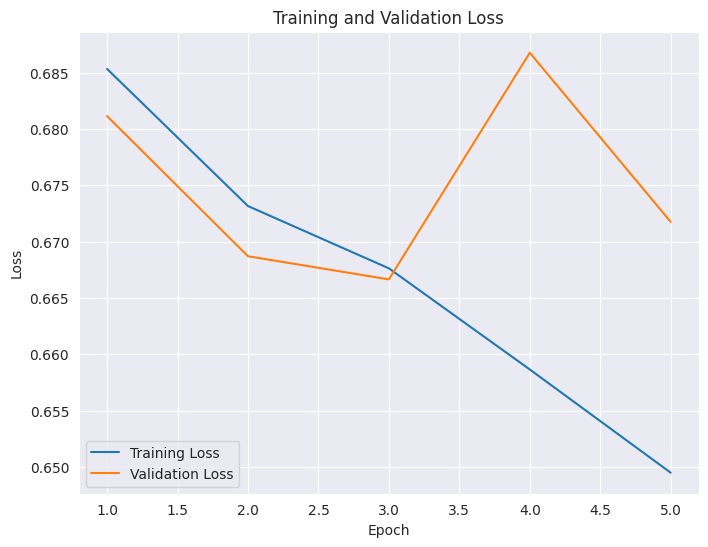

In [194]:
# Plot losses
plt.figure(figsize=(8, 6))
plt.plot(range(1, 5 + 1), training_losses, label='Training Loss')
plt.plot(range(1, 5 + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [195]:
def plot_confusion_matrices(matrices):
    ALLERGENS = [
        "Cereals containing gluten", "Crustaceans", "Eggs", "Fish",
        "Peanuts", "Soybeans", "Milk", "Nuts", "Celery", "Mustard",
        "Sesame seeds",  "Sulphur dioxide and sulphites", "Lupin", "Molluscs"
    ]

    # Plot matrices on seaborn
    for i, matrix in enumerate(matrices):
        plt.figure(figsize=(4, 3))
        sns.heatmap(
            matrix,
            annot=True,
            fmt="d",
            cmap="Reds",
            cbar=False,
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"]
        )
        plt.title(f"Confusion Matrix: {ALLERGENS[i]}")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.tight_layout()
        plt.show()

In [198]:
# https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
from sklearn.metrics import confusion_matrix

def test_loop(dataloader, model):
    model.eval()
    total, correct = 0, 0
    all_predictions = []
    all_actual = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputLogits = model(images)
            probs = torch.sigmoid(outputLogits) # # Apply sigmoid to convert logits to get probabilities 0-1
            preds = (probs > prediction_threshold).long() # Get binary predictions based on prediction threshold param

            total += labels.numel()
            correct += (preds == labels).sum().item()

            all_predictions.append(preds.cpu().numpy())
            all_actual.append(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Test Error: \n Accuracy: {accuracy:.2f} % \n\n')

    all_predictions = np.concatenate(all_predictions, axis=0)
    all_actual = np.concatenate(all_actual, axis=0)

    matrix = confusion_matrix(all_actual, all_predictions)
    print(matrix)

In [199]:
test_loop(test_dataloader, model)

Test Error: 
 Accuracy: 58.54 % 


[[1238  791]
 [ 891 1137]]
